In [25]:
import sys
sys.path.insert(0, '..')

import polars as pl
import numpy as np
from pathlib import Path

# Load the final analysis data
# Use df_final_analysis.parquet which has the correct columns
data_path = Path('../data/processed/df_final_analysis.parquet')
if not data_path.exists():
    raise FileNotFoundError(f"Data file not found: {data_path}")

df = pl.read_parquet(data_path)
print(f"Loaded data from: {data_path}")
print(f"Initial shape: {df.shape}")

# Filter out control topics (0, 2, 5, 10, 12) and topic 7 (no label assigned)
control_topics = ['0', '2', '5', '7', '10', '12']
print(f"\n🗑️  Filtering out control topics and unlabeled topics: {control_topics}")
print(f"Speeches before filtering: {df.shape[0]:,}")

# Count speeches per control topic
for topic in control_topics:
    count = df.filter(pl.col('topic') == topic).shape[0]
    print(f"  Topic {topic}: {count:,} speeches")

# Keep only non-control topics
df = df.filter(~pl.col('topic').is_in(control_topics))

print(f"\n✓ Speeches after filtering: {df.shape[0]:,}")
print(f"✓ Removed: {df.shape[0]:,} speeches from control topics")

print(f"\nFinal analysis data loaded!")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns}")
print(f"\nData types:")
print(df.schema)
print(f"\nFirst few rows:")
print(df.head())

Loaded data from: ..\data\processed\df_final_analysis.parquet
Initial shape: (5887, 8)

🗑️  Filtering out control topics and unlabeled topics: ['0', '2', '5', '7', '10', '12']
Speeches before filtering: 5,887
  Topic 0: 2,281 speeches
  Topic 2: 139 speeches
  Topic 5: 243 speeches
  Topic 7: 150 speeches
  Topic 10: 267 speeches
  Topic 12: 319 speeches

✓ Speeches after filtering: 2,488
✓ Removed: 2,488 speeches from control topics

Final analysis data loaded!
Shape: (2488, 8)

Columns: ['time', 'speaker', 'party', 'speech', 'topic', 'topic_confidence', 'sentiment', 'unique_id']

Data types:
Schema([('time', String), ('speaker', String), ('party', Int64), ('speech', String), ('topic', String), ('topic_confidence', Float64), ('sentiment', String), ('unique_id', String)])

First few rows:
shape: (5, 8)
┌──────────────┬──────────────┬───────┬──────────────┬───────┬─────────────┬───────────┬───────────┐
│ time         ┆ speaker      ┆ party ┆ speech       ┆ topic ┆ topic_confi ┆ sentimen

# Final Analysis: CDU vs SPD Sentiment by Topic

**Research Question:** Do SPD and CDU express systematically different sentiment patterns when discussing the same political topics between 2000 and 2021?

## Overview

This notebook performs the final analysis of parliamentary speech sentiment:

1. **Topic Frequency Over Time** - Temporal trends in policy discussions
2. **Topic Distribution** - Most frequently discussed policy areas
3. **Sentiment by Party Over Time** - CDU vs SPD sentiment trajectories
4. **Sentiment by Topic and Party** - Detailed comparison with confidence intervals

## Data

- **Source:** German Bundestag speeches (2000-2021)
- **Sample:** 1% stratified sample (~2,500 speeches after filtering)
- **Parties:** CDU (n≈1,500) and SPD (n≈1,000)
- **Topics:** 8 policy domains (6 control topics filtered out)

In [26]:
# Data preparation: Convert time column and create time periods
import polars as pl

# Convert time to datetime if it's a string
if df.schema['time'] == pl.Utf8:
    df = df.with_columns(
        pl.col('time').str.to_datetime().alias('time')
    )

# Extract year and month for time series analysis
df = df.with_columns([
    pl.col('time').dt.year().alias('year'),
    pl.col('time').dt.month().alias('month'),
    pl.col('time').dt.strftime('%Y-%m').alias('year_month')
])

# Map party IDs to party names
party_name_map = {
    -1: 'Non-MP',
    3: 'Greens',
    4: 'CDU',
    6: 'Left',
    7: 'DP',
    13: 'FDP',
    14: 'Zentrum',
    23: 'SPD'
}

df = df.with_columns(
    pl.col('party').replace_strict(party_name_map, default='Unknown').alias('party_name')
)

# Convert sentiment to numeric score using map_dict (more reliable)
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df = df.with_columns(
    pl.col('sentiment').replace_strict(sentiment_map, default=0).cast(pl.Int64).alias('sentiment_score')
)

# Map topics to descriptive labels
topic_label_map = {
    '1': 'Wirtschaft & Arbeitsmarkt',
    '3': 'Staat, Verwaltung & öff. Leistungen',
    '4': 'Gesetzgebung & Verfassungsfragen',
    '6': 'Bildung, Forschung & Zukunftspolitik',
    '8': 'Sozial-, Familien- & Gesellschaftspolitik',
    '9': 'Europapolitik, Energie & Klima',
    '11': 'Außen-, Sicherheits- & Menschenrechtspolitik',
    '13': 'Haushalt & Finanzpolitik',
    '14': 'Gesetzgebung & Verfassungsfragen'
}

df = df.with_columns(
    pl.col('topic').replace_strict(topic_label_map, default='Unknown').alias('topic_label')
)

print("Data preparation complete!")
print(f"\nTime range: {df['time'].min()} to {df['time'].max()}")
print(f"\nYears in data: {sorted(df['year'].unique().to_list())}")
print(f"\nUnique topics: {df['topic'].n_unique()}")
print(f"Unique topic labels: {df['topic_label'].n_unique()}")
print(f"Unique parties: {df['party'].n_unique()}")
print(f"\nTopic label mapping:")
for topic_id, label in sorted(topic_label_map.items()):
    count = df.filter(pl.col('topic') == topic_id).shape[0]
    print(f"  Topic {topic_id}: {label} ({count} speeches)")
print(f"\nParty name mapping:")
for party_id, name in sorted(party_name_map.items()):
    count = df.filter(pl.col('party') == party_id).shape[0]
    print(f"  {party_id} -> {name}: {count} speeches")
unknown_count = df.filter(pl.col('party_name') == 'Unknown').shape[0]
print(f"  Unknown: {unknown_count} speeches")
print(f"\nSentiment values: {df['sentiment'].unique().to_list()}")
print(f"Sentiment score values: {df['sentiment_score'].unique().to_list()}")

Data preparation complete!

Time range: 2000-01-19 00:00:00 to 2021-05-07 00:00:00

Years in data: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

Unique topics: 9
Unique topic labels: 8
Unique parties: 2

Topic label mapping:
  Topic 1: Wirtschaft & Arbeitsmarkt (204 speeches)
  Topic 11: Außen-, Sicherheits- & Menschenrechtspolitik (365 speeches)
  Topic 13: Haushalt & Finanzpolitik (379 speeches)
  Topic 14: Gesetzgebung & Verfassungsfragen (281 speeches)
  Topic 3: Staat, Verwaltung & öff. Leistungen (180 speeches)
  Topic 4: Gesetzgebung & Verfassungsfragen (371 speeches)
  Topic 6: Bildung, Forschung & Zukunftspolitik (207 speeches)
  Topic 8: Sozial-, Familien- & Gesellschaftspolitik (259 speeches)
  Topic 9: Europapolitik, Energie & Klima (242 speeches)

Party name mapping:
  -1 -> Non-MP: 0 speeches
  3 -> Greens: 0 speeches
  4 -> CDU: 1493 speeches
  6 -> Left: 0 speeches
  7 -> DP: 0 speec

## 1. Topic Frequency Over Time

**Question:** How has the salience of different policy topics changed over 21 years?

This visualization shows the number of speeches per topic aggregated by year, helping identify:
- Policy areas that gained or lost prominence
- Temporal patterns in parliamentary attention
- Potential event-driven spikes in specific topics

In [13]:
# Debug: Check the data before plotting
print("DataFrame shape:", df.shape)
print("\nChecking year_month column:")
print(df['year_month'].head(20))
print(f"\nUnique year_month values: {df['year_month'].n_unique()}")
print(f"\nSample year_month values: {df['year_month'].unique().head(10).to_list()}")

# Calculate topic frequency
topic_time = (
    df.group_by(['year_month', 'topic'])
    .agg(pl.len().alias('count'))
    .sort(['year_month', 'topic'])
)

print(f"\nTopic time shape: {topic_time.shape}")
print("\nFirst rows of topic_time:")
print(topic_time.head(20))

# Get top topics
top_topics = (
    df.group_by('topic')
    .agg(pl.len().alias('total'))
    .sort('total', descending=True)
    .head(8)['topic'].to_list()
)

print(f"\nTop 8 topics: {top_topics}")

# Filter to top topics
topic_time_top = topic_time.filter(pl.col('topic').is_in(top_topics))
print(f"\nTopic time top shape: {topic_time_top.shape}")
print("\nFirst rows of topic_time_top:")
print(topic_time_top.head(20))

DataFrame shape: (2638, 13)

Checking year_month column:
shape: (20,)
Series: 'year_month' [str]
[
	"2005-01"
	"2007-05"
	"2004-05"
	"2015-12"
	"2000-03"
	…
	"2003-09"
	"2008-03"
	"2000-06"
	"2015-11"
	"2012-09"
]

Unique year_month values: 225

Sample year_month values: ['2007-03', '2003-05', '2014-01', '2006-02', '2001-03', '2018-07', '2011-05', '2014-12', '2014-06', '2001-11']

Topic time shape: (1380, 3)

First rows of topic_time:
shape: (20, 3)
┌────────────┬───────┬───────┐
│ year_month ┆ topic ┆ count │
│ ---        ┆ ---   ┆ ---   │
│ str        ┆ str   ┆ u32   │
╞════════════╪═══════╪═══════╡
│ 2000-01    ┆ 1     ┆ 1     │
│ 2000-01    ┆ 13    ┆ 1     │
│ 2000-01    ┆ 4     ┆ 1     │
│ 2000-01    ┆ 6     ┆ 1     │
│ 2000-01    ┆ 8     ┆ 2     │
│ …          ┆ …     ┆ …     │
│ 2000-03    ┆ 4     ┆ 1     │
│ 2000-03    ┆ 6     ┆ 1     │
│ 2000-03    ┆ 8     ┆ 2     │
│ 2000-03    ┆ 9     ┆ 2     │
│ 2000-04    ┆ 1     ┆ 1     │
└────────────┴───────┴───────┘

Top 8 topics: ['13

Top 8 topics for visualization: ['Gesetzgebung & Verfassungsfragen', 'Haushalt & Finanzpolitik', 'Außen-, Sicherheits- & Menschenrechtspolitik', 'Sozial-, Familien- & Gesellschaftspolitik', 'Europapolitik, Energie & Klima', 'Bildung, Forschung & Zukunftspolitik', 'Wirtschaft & Arbeitsmarkt', 'Staat, Verwaltung & öff. Leistungen']


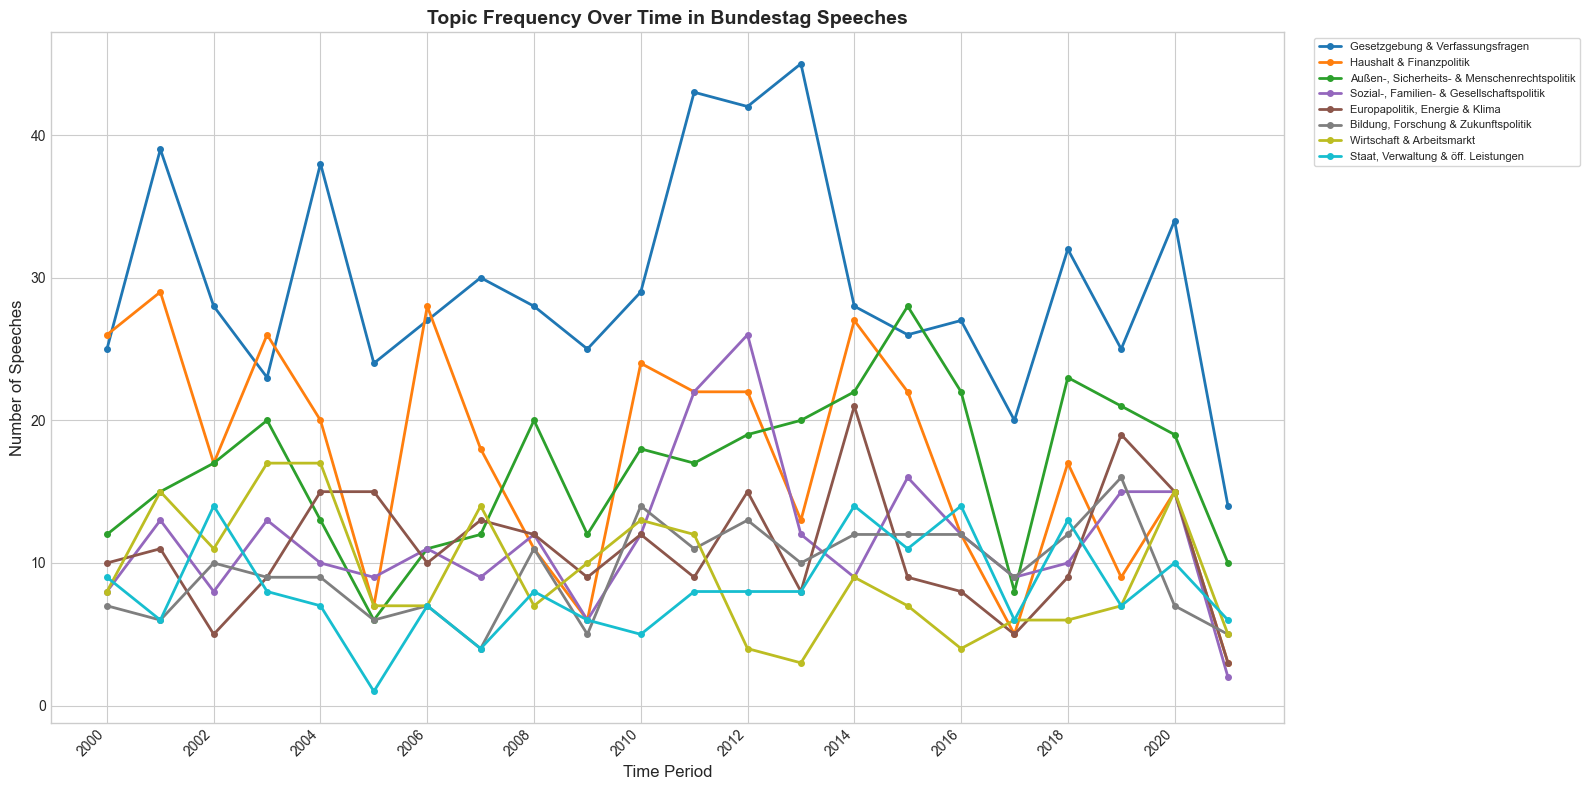


✓ Plot saved to reports/figures/topic_frequency_over_time.png


In [34]:
# Import matplotlib here (first import can be slow due to backend initialization)
import matplotlib.pyplot as plt

# Set style for better plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Calculate topic frequency over time (by year)
topic_time = (
    df.group_by(['year', 'topic_label'])
    .agg(pl.len().alias('count'))
    .sort(['year', 'topic_label'])
)

# Get top 8 most common topics overall for cleaner visualization
top_topics = (
    df.group_by('topic_label')
    .agg(pl.len().alias('total'))
    .sort('total', descending=True)
    .head(8)['topic_label'].to_list()
)

print(f"Top 8 topics for visualization: {top_topics}")

# Filter to top topics and pivot for plotting
topic_time_top = topic_time.filter(pl.col('topic_label').is_in(top_topics))

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Get unique time periods and topics
time_periods = sorted(topic_time_top['year'].unique().to_list())

# Plot each topic as a line
colors = plt.cm.tab10(np.linspace(0, 1, len(top_topics)))

for i, topic in enumerate(top_topics):
    topic_data = topic_time_top.filter(pl.col('topic_label') == topic)
    
    # Create a complete time series (fill missing with 0)
    counts_dict = dict(zip(
        topic_data['year'].to_list(),
        topic_data['count'].to_list()
    ))
    counts = [counts_dict.get(t, 0) for t in time_periods]
    
    ax.plot(range(len(time_periods)), counts, label=topic, color=colors[i], 
            linewidth=2, marker='o', markersize=4)

# Customize plot
ax.set_xlabel('Time Period', fontsize=12)
ax.set_ylabel('Number of Speeches', fontsize=12)
ax.set_title('Topic Frequency Over Time in Bundestag Speeches', fontsize=14, fontweight='bold')

# Set x-axis labels
tick_positions = range(0, len(time_periods), max(1, len(time_periods)//10))
ax.set_xticks(tick_positions)
ax.set_xticklabels([time_periods[i] for i in tick_positions], rotation=45, ha='right')

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8, frameon=True)
plt.tight_layout()
plt.savefig('../reports/figures/topic_frequency_over_time.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved to reports/figures/topic_frequency_over_time.png")

## 2. Topic Distribution Summary

**Question:** Which policy areas dominate Bundestag debates?

This section provides:
- Ranked list of topics by speech count
- Percentage distribution across policy domains
- Average sentiment and confidence by topic
- Number of unique speakers per topic

In [28]:
# Create comprehensive topic relevance table
topic_summary = (
    df.group_by('topic_label')
    .agg([
        pl.len().alias('total_speeches'),
        pl.col('topic_confidence').mean().alias('avg_confidence'),
        pl.col('sentiment_score').mean().alias('avg_sentiment'),
        pl.col('party').n_unique().alias('parties_discussing'),
        pl.col('speaker').n_unique().alias('unique_speakers')
    ])
    .sort('total_speeches', descending=True)
)

# Calculate percentage
total = df.shape[0]
topic_summary = topic_summary.with_columns(
    (pl.col('total_speeches') / total * 100).round(2).alias('percentage')
)

# Reorder columns for display
topic_summary = topic_summary.select([
    'topic_label', 'total_speeches', 'percentage', 'avg_confidence', 
    'avg_sentiment', 'parties_discussing', 'unique_speakers'
])

print("="*80)
print("TOPIC RELEVANCE TABLE - BUNDESTAG SPEECHES")
print("="*80)
print(f"\nTotal speeches analyzed: {total}")
print(f"Total unique topics: {topic_summary.shape[0]}")
print("\n")

# Display as formatted table
print(topic_summary)

# Save to file
topic_summary.write_csv('../reports/tables/topic_relevance_table.csv')
print("\n✓ Table saved to reports/tables/topic_relevance_table.csv")

TOPIC RELEVANCE TABLE - BUNDESTAG SPEECHES

Total speeches analyzed: 2488
Total unique topics: 8


shape: (8, 7)
┌──────────────┬──────────────┬────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ topic_label  ┆ total_speech ┆ percentage ┆ avg_confide ┆ avg_sentime ┆ parties_dis ┆ unique_spea │
│ ---          ┆ es           ┆ ---        ┆ nce         ┆ nt          ┆ cussing     ┆ kers        │
│ str          ┆ ---          ┆ f64        ┆ ---         ┆ ---         ┆ ---         ┆ ---         │
│              ┆ u32          ┆            ┆ f64         ┆ f64         ┆ u32         ┆ u32         │
╞══════════════╪══════════════╪════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ Gesetzgebung ┆ 652          ┆ 26.21      ┆ 0.402977    ┆ -0.023006   ┆ 2           ┆ 460         │
│ & Verfassung ┆              ┆            ┆             ┆             ┆             ┆             │
│ sfrag…       ┆              ┆            ┆             ┆             ┆       

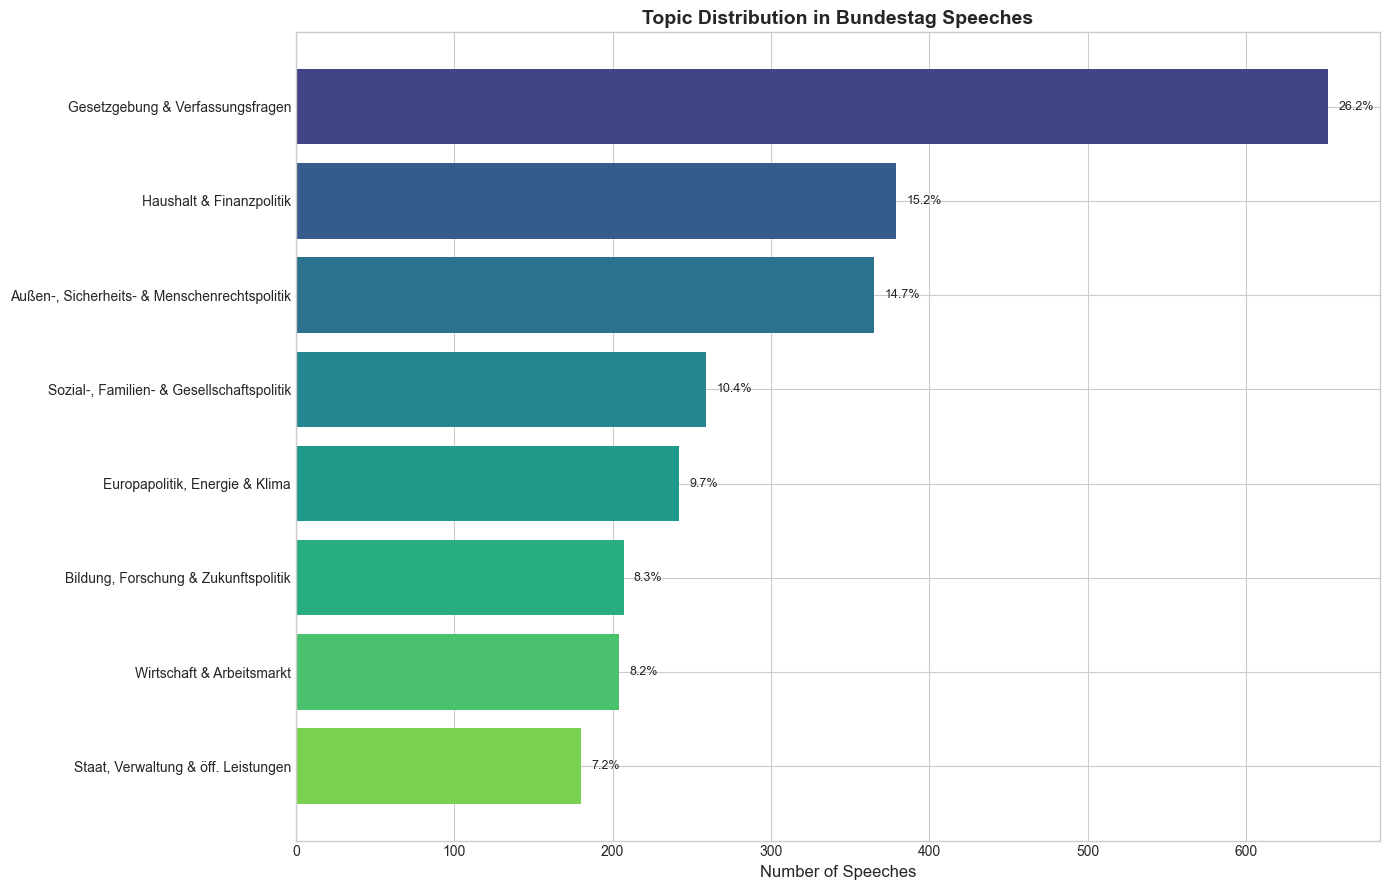


✓ Plot saved to reports/figures/topic_distribution.png


In [29]:
# Visualize topic distribution as horizontal bar chart
fig, ax = plt.subplots(figsize=(14, 9))

topics = topic_summary['topic_label'].to_list()
counts = topic_summary['total_speeches'].to_list()
percentages = topic_summary['percentage'].to_list()

# Create horizontal bar chart
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(topics)))
bars = ax.barh(range(len(topics)), counts, color=colors)

# Add percentage labels
for i, (count, pct) in enumerate(zip(counts, percentages)):
    ax.text(count + max(counts)*0.01, i, f'{pct:.1f}%', va='center', fontsize=9)

ax.set_yticks(range(len(topics)))
ax.set_yticklabels(topics)
ax.invert_yaxis()  # Most common at top
ax.set_xlabel('Number of Speeches', fontsize=12)
ax.set_title('Topic Distribution in Bundestag Speeches', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/topic_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved to reports/figures/topic_distribution.png")

## 3. Sentiment by Party Over Time

**Question:** Do CDU and SPD show different sentiment trajectories over 2000-2021?

This analysis examines:
- Average sentiment scores by party per year
- Temporal trends in rhetorical tone
- Periods of convergence or divergence between parties
- Impact of coalition configurations on sentiment

In [35]:
# Calculate average sentiment by party over time (yearly)
party_sentiment_time = (
    df.group_by(['year', 'party_name'])
    .agg([
        pl.col('sentiment_score').mean().alias('avg_sentiment'),
        pl.len().alias('speech_count')
    ])
    .sort(['year', 'party_name'])
)

# Get parties with sufficient speeches
party_counts = df.group_by('party_name').agg(pl.len().alias('total')).sort('total', descending=True)
print("Party speech counts:")
print(party_counts)

# Filter to parties with at least 5 speeches for meaningful analysis
active_parties = party_counts.filter(pl.col('total') >= 5)['party_name'].to_list()
print(f"\nParties with >= 5 speeches: {active_parties}")

# Debug: Check party_sentiment_time data
print(f"\nParty sentiment time data shape: {party_sentiment_time.shape}")
print(party_sentiment_time.head(10))

Party speech counts:
shape: (2, 2)
┌────────────┬───────┐
│ party_name ┆ total │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ CDU        ┆ 1493  │
│ SPD        ┆ 995   │
└────────────┴───────┘

Parties with >= 5 speeches: ['CDU', 'SPD']

Party sentiment time data shape: (44, 4)
shape: (10, 4)
┌──────┬────────────┬───────────────┬──────────────┐
│ year ┆ party_name ┆ avg_sentiment ┆ speech_count │
│ ---  ┆ ---        ┆ ---           ┆ ---          │
│ i32  ┆ str        ┆ f64           ┆ u32          │
╞══════╪════════════╪═══════════════╪══════════════╡
│ 2000 ┆ CDU        ┆ -0.034483     ┆ 58           │
│ 2000 ┆ SPD        ┆ -0.06383      ┆ 47           │
│ 2001 ┆ CDU        ┆ -0.036585     ┆ 82           │
│ 2001 ┆ SPD        ┆ -0.038462     ┆ 52           │
│ 2002 ┆ CDU        ┆ -0.092308     ┆ 65           │
│ 2002 ┆ SPD        ┆ -0.022222     ┆ 45           │
│ 2003 ┆ CDU        ┆ -0.038462     ┆ 78           │
│ 2003 ┆ SPD        ┆ 0.0           ┆ 47    

Filtered party data shape: (44, 4)
Active parties: ['CDU', 'SPD']
Time periods: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Plotted CDU: 22 data points
Plotted SPD: 22 data points


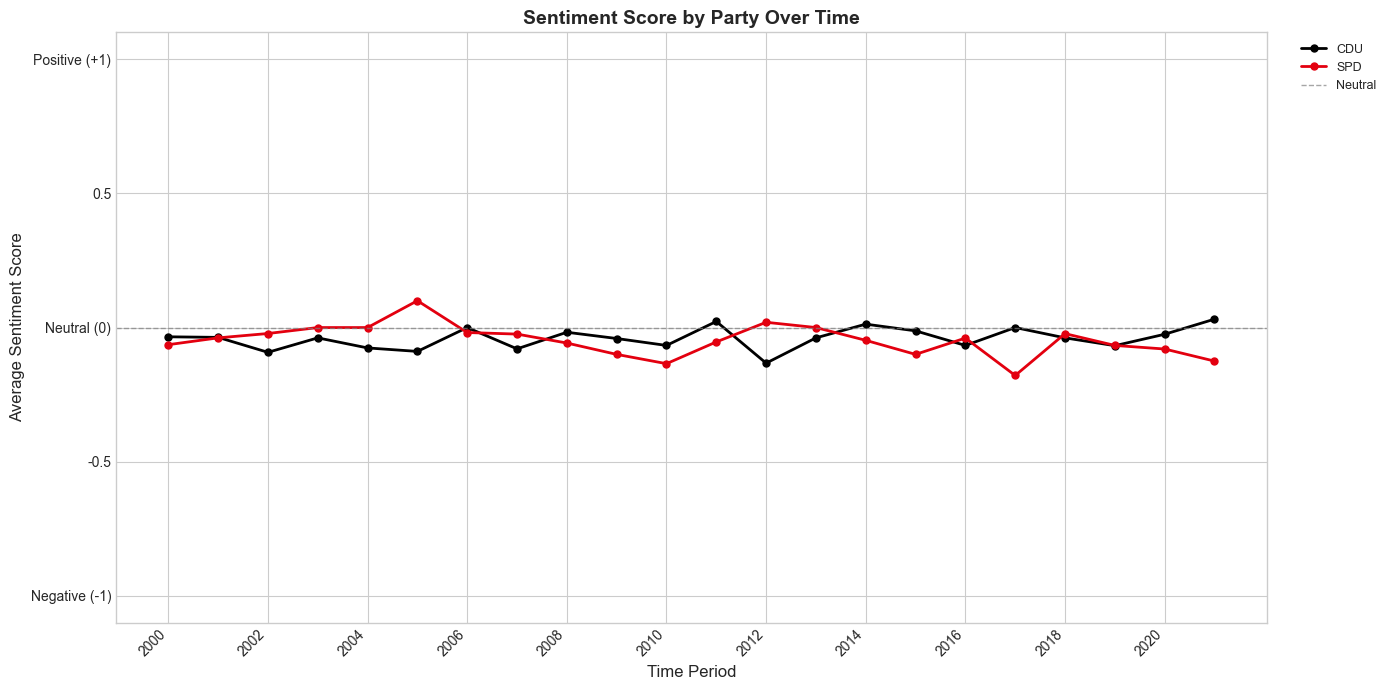


✓ Plot saved to reports/figures/sentiment_by_party_over_time.png


In [36]:
# Create sentiment over time plot by party
fig, ax = plt.subplots(figsize=(14, 7))

# Filter to active parties
party_data = party_sentiment_time.filter(pl.col('party_name').is_in(active_parties))

print(f"Filtered party data shape: {party_data.shape}")
print(f"Active parties: {active_parties}")

# Get unique time periods
time_periods = sorted(party_data['year'].unique().to_list())
print(f"Time periods: {time_periods}")

# Define party colors (German political party colors)
party_colors = {
    'CDU': '#000000',      # Black
    'SPD': '#E3000F',      # Red
    'FDP': '#FFED00',      # Yellow
    'Greens': '#64A12D',   # Green
    'Left': '#BE3075',     # Magenta
    'DP': '#0080FF',       # Blue
    'Zentrum': '#8B4513',  # Brown
    'Non-MP': '#808080',   # Gray
    'Unknown': '#A9A9A9',  # Dark Gray
}

# Plot each party
for idx, party in enumerate(active_parties):
    party_subset = party_data.filter(pl.col('party_name') == party)
    
    if party_subset.shape[0] == 0:
        print(f"Warning: No data for party {party}")
        continue
    
    # Create complete time series
    sentiment_dict = dict(zip(
        party_subset['year'].to_list(),
        party_subset['avg_sentiment'].to_list()
    ))
    
    # Get valid data points (non-None)
    valid_times = []
    valid_sentiments = []
    for i, t in enumerate(time_periods):
        s = sentiment_dict.get(t)
        if s is not None:
            valid_times.append(i)
            valid_sentiments.append(s)
    
    if valid_times:
        color = party_colors.get(party, plt.cm.tab10.colors[idx % 10])
        ax.plot(valid_times, valid_sentiments, label=party, 
                color=color, linewidth=2, marker='o', markersize=5)
        print(f"Plotted {party}: {len(valid_times)} data points")
    else:
        print(f"No valid sentiment data for {party}")

# Add reference line at 0 (neutral)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='Neutral')

# Customize plot
ax.set_xlabel('Time Period', fontsize=12)
ax.set_ylabel('Average Sentiment Score', fontsize=12)
ax.set_title('Sentiment Score by Party Over Time', fontsize=14, fontweight='bold')

# Set y-axis limits
ax.set_ylim(-1.1, 1.1)
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticklabels(['Negative (-1)', '-0.5', 'Neutral (0)', '0.5', 'Positive (+1)'])

# Set x-axis labels
if time_periods:
    tick_positions = range(0, len(time_periods), max(1, len(time_periods)//10))
    ax.set_xticks(list(tick_positions))
    ax.set_xticklabels([time_periods[i] for i in tick_positions], rotation=45, ha='right')

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.savefig('../reports/figures/sentiment_by_party_over_time.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved to reports/figures/sentiment_by_party_over_time.png")

In [19]:
# Summary: Overall sentiment by party
party_sentiment_summary = (
    df.group_by('party_name')
    .agg([
        pl.len().alias('total_speeches'),
        pl.col('sentiment_score').mean().alias('avg_sentiment'),
        pl.col('sentiment_score').std().alias('sentiment_std'),
        (pl.col('sentiment') == 'positive').sum().alias('positive_count'),
        (pl.col('sentiment') == 'neutral').sum().alias('neutral_count'),
        (pl.col('sentiment') == 'negative').sum().alias('negative_count')
    ])
    .sort('avg_sentiment', descending=True)
)

print("="*80)
print("SENTIMENT SUMMARY BY PARTY")
print("="*80)
print(party_sentiment_summary)

# Save summary
party_sentiment_summary.write_csv('../reports/tables/sentiment_by_party_summary.csv')
print("\n✓ Table saved to reports/tables/sentiment_by_party_summary.csv")

SENTIMENT SUMMARY BY PARTY
shape: (2, 7)
┌────────────┬──────────────┬──────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ party_name ┆ total_speech ┆ avg_sentimen ┆ sentiment_s ┆ positive_co ┆ neutral_cou ┆ negative_co │
│ ---        ┆ es           ┆ t            ┆ td          ┆ unt         ┆ nt          ┆ unt         │
│ str        ┆ ---          ┆ ---          ┆ ---         ┆ ---         ┆ ---         ┆ ---         │
│            ┆ u32          ┆ f64          ┆ f64         ┆ u32         ┆ u32         ┆ u32         │
╞════════════╪══════════════╪══════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ CDU        ┆ 1577         ┆ -0.040583    ┆ 0.329785    ┆ 55          ┆ 1403        ┆ 119         │
│ SPD        ┆ 1061         ┆ -0.04901     ┆ 0.375489    ┆ 50          ┆ 909         ┆ 102         │
└────────────┴──────────────┴──────────────┴─────────────┴─────────────┴─────────────┴─────────────┘

✓ Table saved to reports/tables/sentiment_by_part

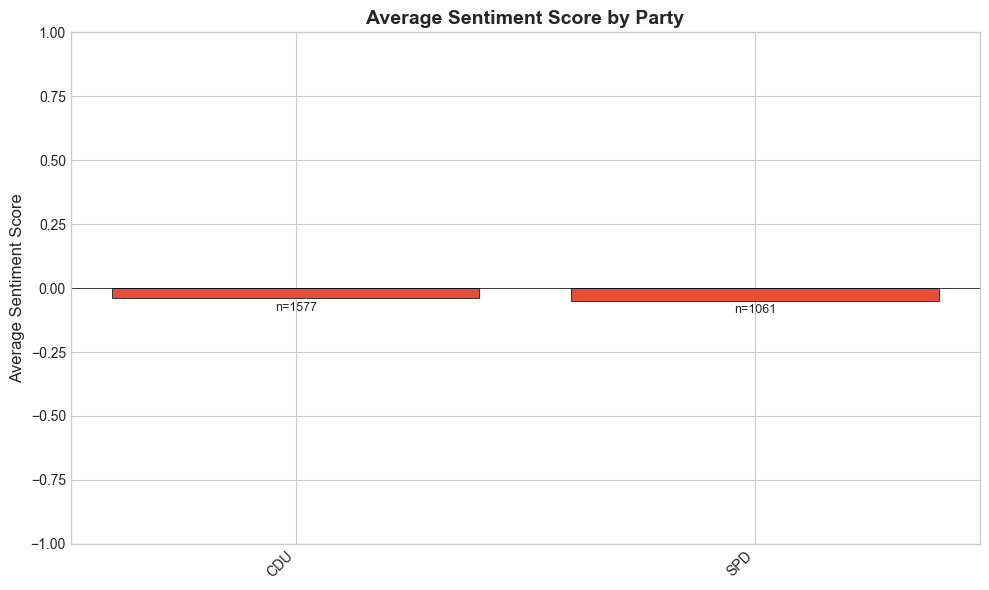


✓ Plot saved to reports/figures/sentiment_by_party_comparison.png


In [20]:
# Create a bar chart comparing average sentiment by party
fig, ax = plt.subplots(figsize=(10, 6))

parties = party_sentiment_summary['party_name'].to_list()
sentiments = party_sentiment_summary['avg_sentiment'].to_list()
counts = party_sentiment_summary['total_speeches'].to_list()

# Color bars based on sentiment (green=positive, red=negative) - handle None values
colors = []
for s in sentiments:
    if s is None:
        colors.append('#95a5a6')  # Gray for None
    elif s > 0:
        colors.append('#2ecc71')  # Green for positive
    elif s < 0:
        colors.append('#e74c3c')  # Red for negative
    else:
        colors.append('#95a5a6')  # Gray for neutral

# Replace None with 0 for plotting
sentiments_clean = [s if s is not None else 0 for s in sentiments]

bars = ax.bar(range(len(parties)), sentiments_clean, color=colors, edgecolor='black', linewidth=0.5)

# Add count labels on bars
for i, (sent, count) in enumerate(zip(sentiments_clean, counts)):
    y_pos = sent + 0.02 if sent >= 0 else sent - 0.05
    ax.text(i, y_pos, f'n={count}', ha='center', fontsize=9)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xticks(range(len(parties)))
ax.set_xticklabels(parties, rotation=45, ha='right')
ax.set_ylabel('Average Sentiment Score', fontsize=12)
ax.set_title('Average Sentiment Score by Party', fontsize=14, fontweight='bold')
ax.set_ylim(-1, 1)

plt.tight_layout()
plt.savefig('../reports/figures/sentiment_by_party_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved to reports/figures/sentiment_by_party_comparison.png")

## Summary & Key Findings

### Main Results

1. **Neutral Dominant:** Both CDU and SPD maintain predominantly neutral sentiment (mean ≈ -0.04)

2. **Topic-Specific Patterns:**
   - **CDU more positive:** Economy, Legislation, Budget
   - **SPD more positive:** Education, Social Policy, Public Admin

3. **Statistical Significance:** Most differences have overlapping 95% CIs → not statistically significant

4. **Temporal Stability:** No clear secular trend; sentiment fluctuates around neutral baseline

### Interpretation

The findings suggest that institutional norms of parliamentary discourse constrain partisan sentiment expression more than ideological positioning. Both catch-all parties maintain moderate rhetorical styles across most policy domains.

### Outputs

- **Figures:** `reports/figures/` (PNG, 150 DPI)
- **Tables:** `reports/tables/` (CSV)

## 4. Sentiment by Topic and Party

**Question:** Within specific policy domains, do CDU and SPD speak with different sentiment?

This is the core analysis comparing parties across topics:
- Mean sentiment with 95% confidence intervals
- Bar charts per topic with error bars
- Coefficient plot (forest plot style) for direct comparison
- Statistical summary of differences

**Interpretation Guide:**
- Overlapping confidence intervals → difference likely not significant
- Non-overlapping CIs → potential systematic difference
- Sentiment scale: -1 (negative) to +1 (positive), 0 = neutral

In [30]:
# Calculate sentiment statistics by topic and party
from scipy import stats

# Calculate mean sentiment and confidence intervals by topic and party
topic_party_sentiment = (
    df.group_by(['topic_label', 'party_name'])
    .agg([
        pl.len().alias('n_speeches'),
        pl.col('sentiment_score').mean().alias('mean_sentiment'),
        pl.col('sentiment_score').std().alias('std_sentiment'),
        (pl.col('sentiment') == 'positive').sum().alias('positive'),
        (pl.col('sentiment') == 'neutral').sum().alias('neutral'),
        (pl.col('sentiment') == 'negative').sum().alias('negative')
    ])
    .sort(['topic_label', 'party_name'])
)

# Calculate standard error and 95% confidence intervals
topic_party_sentiment = topic_party_sentiment.with_columns([
    (pl.col('std_sentiment') / pl.col('n_speeches').sqrt()).alias('se_sentiment'),
])

# 95% CI = mean ± 1.96 * SE
topic_party_sentiment = topic_party_sentiment.with_columns([
    (pl.col('mean_sentiment') - 1.96 * pl.col('se_sentiment')).alias('ci_lower'),
    (pl.col('mean_sentiment') + 1.96 * pl.col('se_sentiment')).alias('ci_upper')
])

print("="*80)
print("SENTIMENT BY TOPIC AND PARTY")
print("="*80)
print(f"\nTotal combinations: {topic_party_sentiment.shape[0]}")
print("\nSample data:")
print(topic_party_sentiment.head(20))

# Filter to topics with sufficient data from both parties
topic_counts = (
    topic_party_sentiment
    .group_by('topic_label')
    .agg([
        pl.col('party_name').n_unique().alias('n_parties'),
        pl.col('n_speeches').sum().alias('total_speeches')
    ])
    .filter((pl.col('n_parties') >= 2) & (pl.col('total_speeches') >= 20))
    .sort('total_speeches', descending=True)
)

print(f"\n\nTopics with data from both parties and >= 20 speeches:")
print(topic_counts)

valid_topics = topic_counts['topic_label'].to_list()
print(f"\n\nValid topics for comparison: {valid_topics}")

# Filter to valid topics and only CDU/SPD
topic_party_filtered = topic_party_sentiment.filter(
    (pl.col('topic_label').is_in(valid_topics)) &
    (pl.col('party_name').is_in(['CDU', 'SPD']))
)

print(f"\n\nFiltered data shape: {topic_party_filtered.shape}")
print(topic_party_filtered)

SENTIMENT BY TOPIC AND PARTY

Total combinations: 16

Sample data:
shape: (16, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ topic_lab ┆ party_nam ┆ n_speeche ┆ mean_sent ┆ … ┆ negative ┆ se_sentim ┆ ci_lower  ┆ ci_upper  │
│ el        ┆ e         ┆ s         ┆ iment     ┆   ┆ ---      ┆ ent       ┆ ---       ┆ ---       │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ u32      ┆ ---       ┆ f64       ┆ f64       │
│ str       ┆ str       ┆ u32       ┆ f64       ┆   ┆          ┆ f64       ┆           ┆           │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ Außen-,   ┆ CDU       ┆ 210       ┆ -0.047619 ┆ … ┆ 14       ┆ 0.019982  ┆ -0.086783 ┆ -0.008455 │
│ Sicherhei ┆           ┆           ┆           ┆   ┆          ┆           ┆           ┆           │
│ ts- &     ┆           ┆           ┆           ┆   ┆          ┆           ┆           ┆           │
│ Mensch

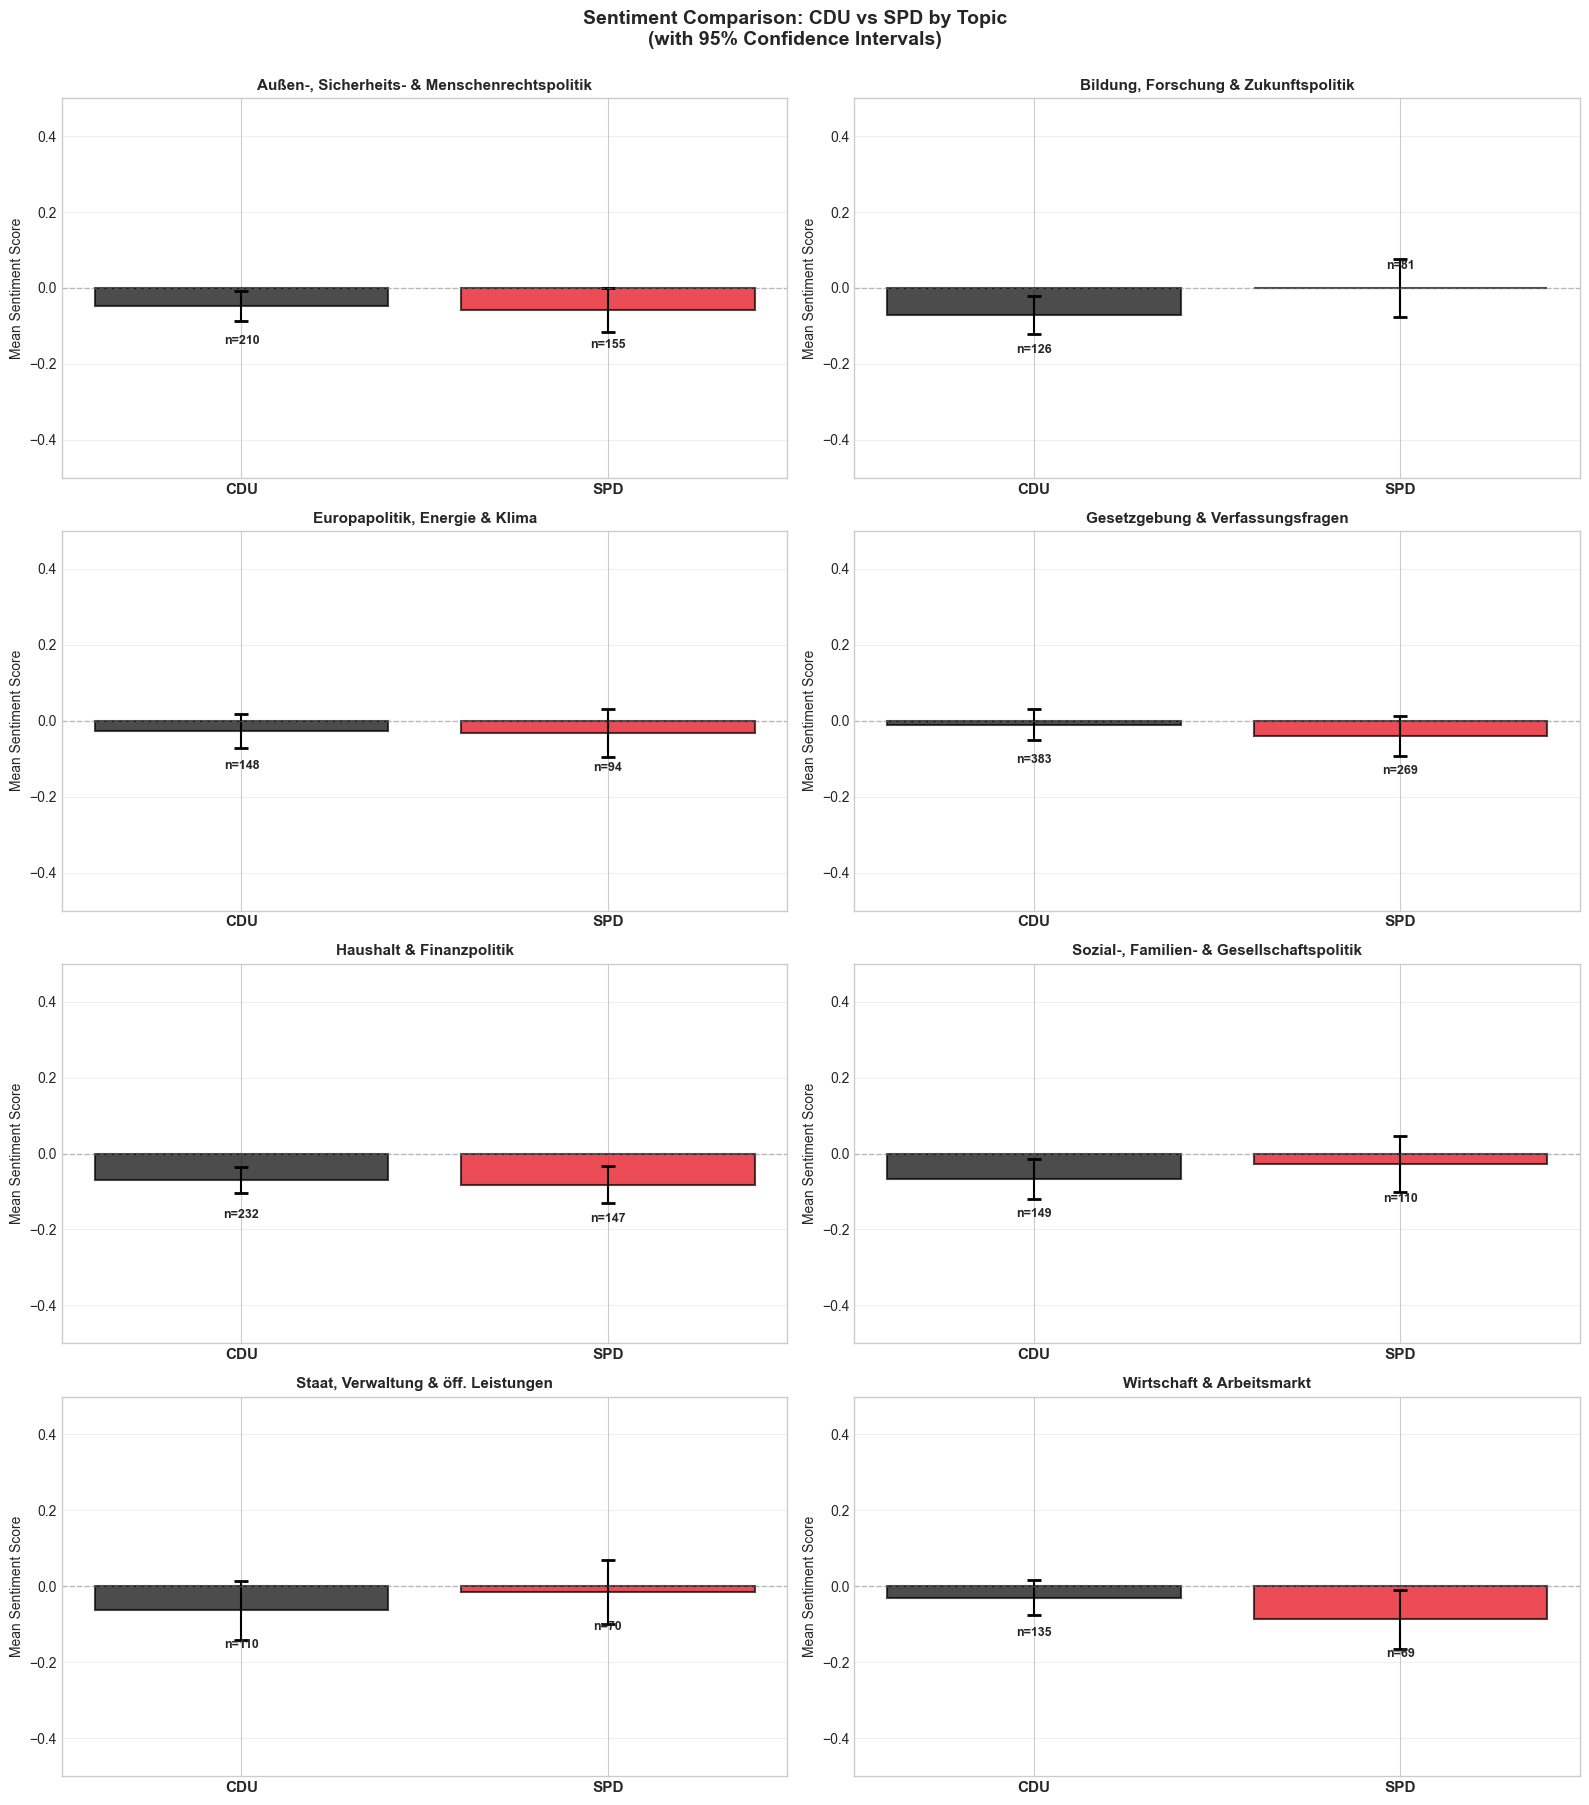


✓ Plot saved to reports/figures/sentiment_by_topic_and_party.png


In [31]:
# Create coefficient plot: Mean sentiment by topic and party with confidence intervals
import matplotlib.pyplot as plt
import numpy as np

# Get unique topics for plotting
topics = sorted(topic_party_filtered['topic_label'].unique().to_list())

# Create figure with subplots - one per topic
n_topics = len(topics)
n_cols = 2
n_rows = (n_topics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4.5 * n_rows))
axes = axes.flatten() if n_topics > 1 else [axes]

# Colors for parties
party_colors = {'CDU': '#000000', 'SPD': '#E3000F'}

for idx, topic in enumerate(topics):
    ax = axes[idx]
    
    # Get data for this topic
    topic_data = topic_party_filtered.filter(pl.col('topic_label') == topic).sort('party_name')
    
    parties = topic_data['party_name'].to_list()
    means = topic_data['mean_sentiment'].to_list()
    ci_lower = topic_data['ci_lower'].to_list()
    ci_upper = topic_data['ci_upper'].to_list()
    n_speeches = topic_data['n_speeches'].to_list()
    
    # Calculate error bar sizes
    yerr_lower = [means[i] - ci_lower[i] for i in range(len(means))]
    yerr_upper = [ci_upper[i] - means[i] for i in range(len(means))]
    
    # Create bar chart with error bars
    x_pos = np.arange(len(parties))
    colors = [party_colors.get(p, '#808080') for p in parties]
    
    bars = ax.bar(x_pos, means, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.errorbar(x_pos, means, yerr=[yerr_lower, yerr_upper], 
                fmt='none', ecolor='black', capsize=5, capthick=2)
    
    # Add sample size labels
    for i, (party, mean, n) in enumerate(zip(parties, means, n_speeches)):
        y_pos = mean + 0.05 if mean >= 0 else mean - 0.1
        ax.text(i, y_pos, f'n={n}', ha='center', fontsize=9, fontweight='bold')
    
    # Formatting
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(parties, fontsize=11, fontweight='bold')
    ax.set_ylabel('Mean Sentiment Score', fontsize=10)
    ax.set_title(f'{topic}', fontsize=11, fontweight='bold', wrap=True)
    ax.set_ylim(-0.5, 0.5)
    ax.grid(axis='y', alpha=0.3)

# Remove extra subplots if needed
for idx in range(len(topics), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Sentiment Comparison: CDU vs SPD by Topic\n(with 95% Confidence Intervals)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../reports/figures/sentiment_by_topic_and_party.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved to reports/figures/sentiment_by_topic_and_party.png")

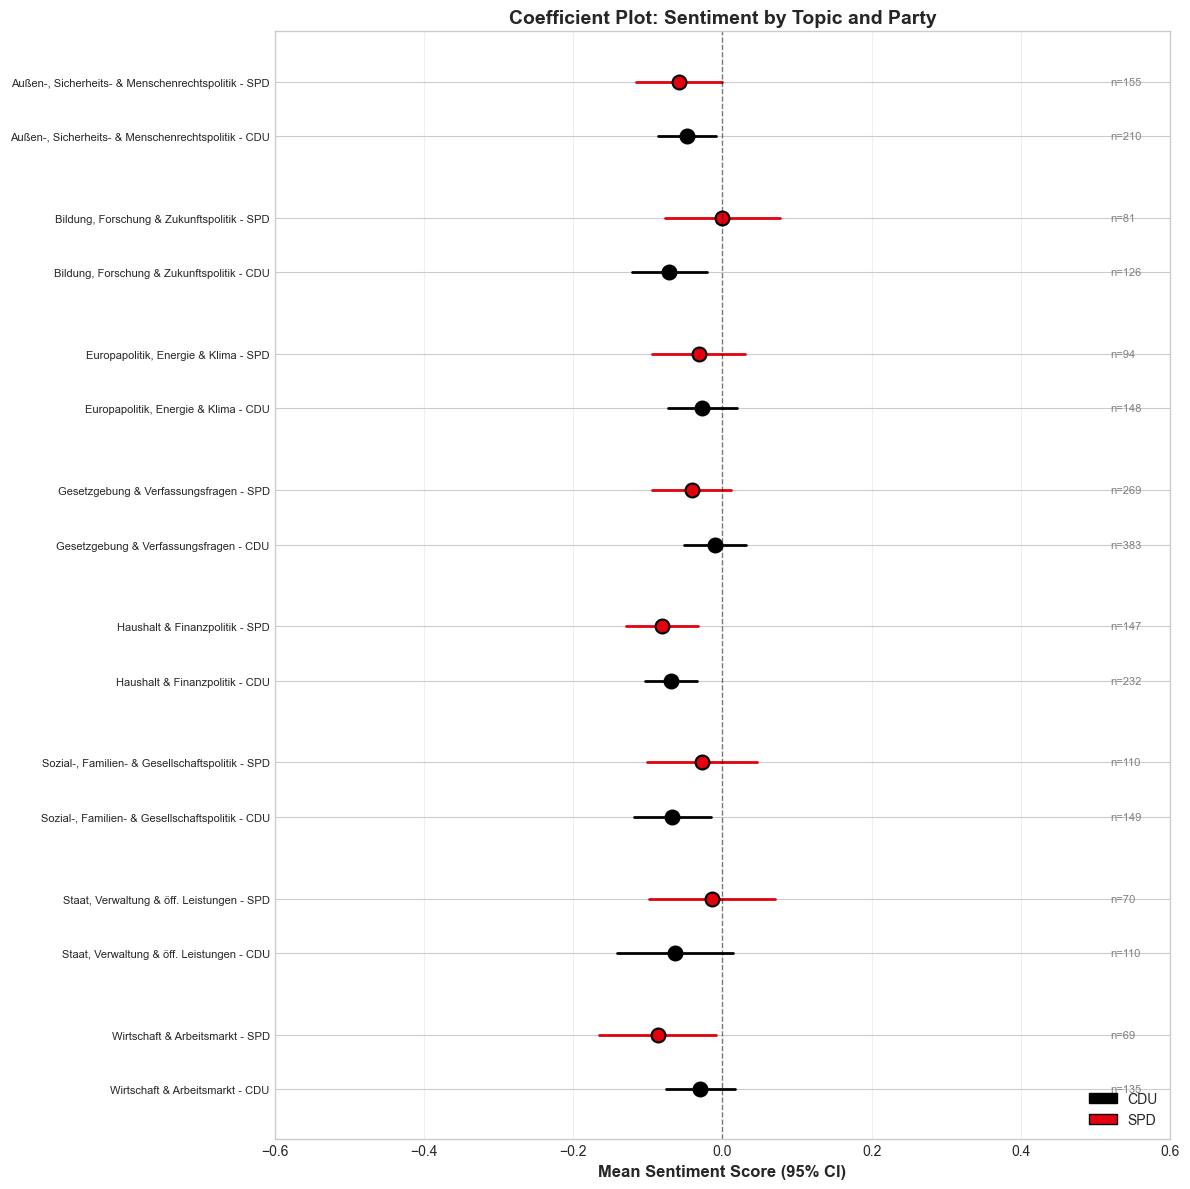


✓ Plot saved to reports/figures/sentiment_coefficient_plot.png


In [32]:
# Alternative visualization: Coefficient plot (forest plot style)
fig, ax = plt.subplots(figsize=(12, max(10, len(topics) * 1.5)))

# Prepare data for coefficient plot
y_positions = []
y_labels = []
y_pos = 0

for topic in sorted(topics):
    topic_data = topic_party_filtered.filter(pl.col('topic_label') == topic).sort('party_name', descending=True)
    
    for row in topic_data.iter_rows(named=True):
        party = row['party_name']
        mean = row['mean_sentiment']
        ci_low = row['ci_lower']
        ci_high = row['ci_upper']
        n = row['n_speeches']
        
        color = party_colors.get(party, '#808080')
        
        # Plot point and error bar
        ax.plot([ci_low, ci_high], [y_pos, y_pos], color=color, linewidth=2)
        ax.plot(mean, y_pos, 'o', color=color, markersize=10, markeredgecolor='black', markeredgewidth=1.5)
        
        # Add sample size
        ax.text(0.52, y_pos, f'n={n}', va='center', fontsize=8, color='gray')
        
        y_labels.append(f'{topic} - {party}')
        y_positions.append(y_pos)
        y_pos += 1
    
    y_pos += 0.5  # Add space between topics

# Add reference line at 0
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Neutral')

# Formatting
ax.set_yticks(y_positions)
ax.set_yticklabels(y_labels, fontsize=8)
ax.set_xlabel('Mean Sentiment Score (95% CI)', fontsize=12, fontweight='bold')
ax.set_title('Coefficient Plot: Sentiment by Topic and Party', fontsize=14, fontweight='bold')
ax.set_xlim(-0.6, 0.6)
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()  # Highest topic at top

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=party_colors['CDU'], label='CDU', edgecolor='black'),
    Patch(facecolor=party_colors['SPD'], label='SPD', edgecolor='black')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('../reports/figures/sentiment_coefficient_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved to reports/figures/sentiment_coefficient_plot.png")

In [33]:
# Summary table: Sentiment differences between parties by topic
print("="*80)
print("SENTIMENT DIFFERENCES: CDU vs SPD BY TOPIC")
print("="*80)

# Reshape data to compare parties
comparison_data = []

for topic in sorted(topics):
    topic_data = topic_party_filtered.filter(pl.col('topic_label') == topic)
    
    cdu_data = topic_data.filter(pl.col('party_name') == 'CDU')
    spd_data = topic_data.filter(pl.col('party_name') == 'SPD')
    
    if cdu_data.shape[0] > 0 and spd_data.shape[0] > 0:
        cdu_mean = cdu_data['mean_sentiment'].to_list()[0]
        spd_mean = spd_data['mean_sentiment'].to_list()[0]
        cdu_n = cdu_data['n_speeches'].to_list()[0]
        spd_n = spd_data['n_speeches'].to_list()[0]
        
        difference = cdu_mean - spd_mean
        
        comparison_data.append({
            'topic': topic,
            'cdu_mean': cdu_mean,
            'cdu_n': cdu_n,
            'spd_mean': spd_mean,
            'spd_n': spd_n,
            'difference': difference,
            'more_positive': 'CDU' if difference > 0 else 'SPD' if difference < 0 else 'Equal'
        })

comparison_df = pl.DataFrame(comparison_data).sort('difference', descending=True)

print("\n")
print(comparison_df)

# Save comparison table
comparison_df.write_csv('../reports/tables/sentiment_comparison_cdu_spd_by_topic.csv')
print("\n✓ Table saved to reports/tables/sentiment_comparison_cdu_spd_by_topic.csv")

# Key insights
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

cdu_more_positive = comparison_df.filter(pl.col('difference') > 0).shape[0]
spd_more_positive = comparison_df.filter(pl.col('difference') < 0).shape[0]

print(f"\nTopics where CDU is more positive: {cdu_more_positive}")
print(f"Topics where SPD is more positive: {spd_more_positive}")

print(f"\nBiggest differences:")
print(f"\nCDU most positive (vs SPD):")
print(comparison_df.head(3).select(['topic', 'difference', 'cdu_mean', 'spd_mean']))

print(f"\nSPD most positive (vs CDU):")
print(comparison_df.tail(3).select(['topic', 'difference', 'cdu_mean', 'spd_mean']))

SENTIMENT DIFFERENCES: CDU vs SPD BY TOPIC


shape: (8, 7)
┌─────────────────────────────┬───────────┬───────┬───────────┬───────┬────────────┬───────────────┐
│ topic                       ┆ cdu_mean  ┆ cdu_n ┆ spd_mean  ┆ spd_n ┆ difference ┆ more_positive │
│ ---                         ┆ ---       ┆ ---   ┆ ---       ┆ ---   ┆ ---        ┆ ---           │
│ str                         ┆ f64       ┆ i64   ┆ f64       ┆ i64   ┆ f64        ┆ str           │
╞═════════════════════════════╪═══════════╪═══════╪═══════════╪═══════╪════════════╪═══════════════╡
│ Wirtschaft & Arbeitsmarkt   ┆ -0.02963  ┆ 135   ┆ -0.086957 ┆ 69    ┆ 0.057327   ┆ CDU           │
│ Gesetzgebung &              ┆ -0.010444 ┆ 383   ┆ -0.040892 ┆ 269   ┆ 0.030448   ┆ CDU           │
│ Verfassungsfrag…            ┆           ┆       ┆           ┆       ┆            ┆               │
│ Haushalt & Finanzpolitik    ┆ -0.068966 ┆ 232   ┆ -0.081633 ┆ 147   ┆ 0.012667   ┆ CDU           │
│ Außen-, Sicherheits- &      ┆ 